# Chapter 11 Train Deep Neural Networks

在第10章中，我们介绍了人工神经网络并训练我们的第一个深度神经网络。但它是一个非常浅的DNN，只有两个隐藏层。如果你需要解决一个非常复杂的问题，例如在高分辨率图像中检测数百种类型的对象，该怎么办？你可能需要训练更深的DNN，可能有（比方说）10层，每层包含数百个神经元，有数十万个连接。这不是一件简单的事：


* 首先，你将面临棘手的梯度消失问题（或者相关的爆炸梯度问题）， 这会影响深层神经网络并使下层很难训练。

* 其次，你可能没有足够多的训练数据，或者是对数据标记的成本非常大。

* 第三，如此庞大的网络，训练将非常缓慢。

* 最后，具有数百万个参数的模型将严重地过度拟合训练集。特别是在没有足够多训练数据和数据中噪声太多的情况下。

在本章中，我们将依次讨论这些问题并提出技术解决它们。

* 我们将首先解释梯度消失问题，并探索一些最常用的解决方案。

* 接下来，我们将研究迁移学习和无监督学习。当你只有很少一部分带标签数据时，这会帮你解决复杂任务。

* 然后，我们将看看各种优化器，与普通的Gradient Descent相比，它可以极大地加速训练大型模型。

* 最后，我们将介绍一些用于大型神经网络的流行正则化技术。

In [1]:
# 只支持 python 3 

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import sklearn
import sys

#让笔记能够准确复现
np.random.seed(42)

#导入绘图工具
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#以函数的形式设定图片的保存路径，后续可以直接调用，也可根据个人情况对路径进行修改
PROJECT_ROOT_DIR = "E:\Hands_on_Machine_Learning"  #文件夹,需要先手动建立文件夹
CHAPTER_ID = "Training Deep Neural Networks_11" #章节名
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID) #完整路径

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300): #resolution控制分辨率，可修改
    path = os.path.join(IMAGES_PATH,fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout() #子图充满
    plt.savefig(path, format=fig_extension, dpi=resolution)  
    
# 忽略无用警告
import warnings
#warnings.filterwarnings(action="ignore", message="^internal gelsd") # 忽略一部分警告
warnings.filterwarnings("ignore")  #忽略所有警告，谨慎使用

## 11.1 Vanishing/Exploding Gradients Problem

正如我们在第10章中讨论过的，反向传播算法的工作原理是从输出层到输入层，在路上传播误差梯度。一旦算法计算了关于网络中每个参数的成本函数的梯度，它就使用这些梯度通过梯度下降步骤更新每个参数。


不幸的是，随着算法进展到较低层，梯度通常会变得越来越小。因此，Gradient Descent更新使得较低层连接权重几乎不变，并且训练永远不会收敛到一个好的数值解。这被称为**梯度消失**问题。在某些情况下，可能会发生相反的情况：梯度可能会变得越来越大，因此很多层都会获得非常大的权重更新，并且算法会发生变化。这是**梯度爆炸**问题，主要在递归神经网络中遇到（见第14章）。更一般地说，深度神经网络受到不稳定梯度的影响;不同的层可以以不同的速度学习。

虽然这种不幸的行为已经在实践中被发现很长一段时间（这就是为什么深度神经网络大多被放弃很久的原因之一），直到2010年左右，在理解它方面才取得了重大进展。一篇由Xavier Glorot和Yoshua Bengio发表的题为“Understanding the Difficulty of Training Deep Feedforward Neural Networks” 的文章发现了一些东西，包括流行的logistic sigmoid激活函数和当时最受欢迎的权重初始化技术，即：使用平均值为0且标准差为1的正态分布进行随机初始化。

简而言之，他们表明，**利用这种激活函数和这种初始化方案，每层输出的方差远大于其输入的方差**。在网络中向前推进，方差在每层之后不断增加，直到激活函数在顶层饱和。事实上，逻辑函数的平均值为0.5，而不是0，这实际上变得更糟（双曲正切函数的平均值为0，并且表现略好于深度网络中的逻辑函数）。

查看逻辑激活函数（见图11-1，即下图），你可以看到当输入变大（负或正）时，函数在0或1饱和，导数非常接近0。因此，当反向传播开始时，它实际上没有梯度传播回网络，并且当反向传播通过顶层向下传播时，存在的小梯度不断被稀释，因此实际上没有任何东西留给下层

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


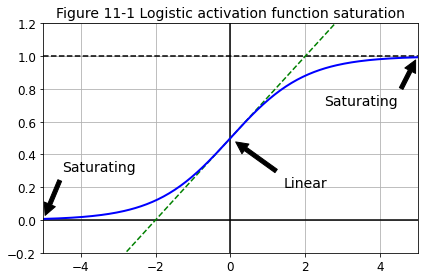

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Figure 11-1 Logistic activation function saturation", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

### 11.1.1Glorot and He Initialization

在他们的论文中，Glorot和Bengio提出了一种显着缓解这一问题的方法。我们需要信号在两个方向上正确流动：

**在进行预测时向前方向，在向后传播梯度时向反方向流动**。

我们不希望信号消失，我们也不希望它爆炸和饱和。为了使信号正常流动，作者认为，我们需要**每层输出的方差等于其输入的方差**，并且我们还需要梯度在逆向流过一层之前和之后具有相等的方差（如果你对数学细节感兴趣，请查看论文）。除非该层具有相同数量的输入和输出连接（这些数量也被称为层的扇入和扇出），否则实际上不可能保证两者，但是他们提出了一个良好的折衷方案，已经证明在实践中非常有效：**连接权重必须如公式11- 1所述随机初始化** ，其中 $fan_{in}$个输入和$fan_{out}$个输出。

公式11-1 Glorot Initialization（当使用逻辑激活函数）：

正态分布的均值为0，方差$\sigma^{2}=\frac{1}{\operatorname{fan}_{\mathrm{avg}}}$

或者从$-r$到$r$的均匀分布，$r=\sqrt{\frac{3}{\mathrm{fan}_{\mathrm{avg}}}}$

其中，$fan_{avg} = (fan_{in} + fan_{out}) / 2$

这种初始化策略通常称为**Xavier初始化**（在作者的名字之后），或者有时称为**Glorot初始化**。

如果你只需将公式11-1中的$fan_{avg}$替换为$fan_{in}$，你就会得到一个初始化策略，这个策略其实在20世纪90年代就已经由Yann LeCun提出了，叫做LeCun初始化。当$fan_{in}=fan_{out}$时，它相当于Glorot初始化。研究人员花了十几年的时间才意识到这个技巧到底有多重要。使用Glorot初始化可以大大加快训练速度，这也是导致目前深度学习成功的窍门之一。

一些论文对不同的激活函数提供了类似的策略。这些策略的不同之处仅在于方差的规模和是否使用$fan_{avg}$或$fan_{in}$，如表11-1所示（对于均匀分布，只需计算$r=\sqrt{3\sigma^2}$）。ReLU激活函数（及其变体，包括稍后描述的ELU激活）的初始化策略有时被称为He初始化（以其作者的姓氏命名）。SELU激活函数将在本章后面解释。它应该与LeCun初始化一起使用（最好是用正态分布，我们将看到）。
![image-20200823145307974](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/23/145309-279525.png)

默认情况下，Keras使用均匀分布的Glorot初始化。你可以使用`kernel_initializer = "he_uniform"`或者`kernel_initializer = "he_normal"`改为He 初始化：

In [4]:
keras.layers.Dense(10, activation = "relu", kernel_initializer = "he_normal")

如果你希望使用均匀分布的 He 初始化，但是基于$fan_{avg}$，而不是$fan_{in}$，你可以使用`VarianceScaling`初始化：

In [5]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                distribution = 'uniform')

keras.layers.Dense(10, activation="sigmoid", kernel_initializer = he_avg_init)

### 11.1.2 Nosaturating Activation Functions

Glorot和Bengio在2010年论文中的见解之一是消失/爆炸梯度问题部分是由于激活函数选择不当。直到那时大多数人都认为，如果大自然母亲选择在生物神经元中使用大致的sigmoid activation functions，它们必定是一个很好的选择。但事实证明，其他激活函数在深度神经网络中表现得更好，尤其是ReLU激活函数，主要是因为它不会为正值饱和（并且还因为计算速度非常快）。


不幸的是，ReLU激活函数并不完美。它遇到了一个被称为垂死的ReLUs的问题：

*  在训练过程中，一些神经元会有效死亡，这意味着它们会停止输出0以外的任何东西。
*  在某些情况下，你可能会发现网络神经元的一半已经死亡，特别是如果你使用了很高的学习率。
* 在训练期间，如果神经元的权重得到更新，使得神经元输入的加权和为负，则它将开始输出0。当这种情况发生时，它就会一直输出0，梯度下降不会再影响它，因为ReLU函数的梯度在其输入为负值时是0。

要解决这个问题，你可能想要使用ReLU功能的变体，例如**Leaky ReLU**。该函数定义为$ Leaky ReLU_α(z)= max(αz，z)$（见图11-2即下图）。

超参数 $α$ 定义函数“Leaky”的程度：它是 $ z < 0 $  时函数的斜率，通常设置为0.01。这个小斜坡确保Leaky ReLU永不死亡;他们可以长时间昏迷，但他们有机会最终醒来。最近的一篇2015年的论文比较了ReLU激活函数的几种变体，其结论之一是**Leaky 变体总是优于严格的ReLU激活函数**。

实际上，设定$α= 0.2（巨大泄漏）$似乎导致比$α= 0.01（小泄漏）$更好的性能。他们还评估了 随机泄漏ReLU（RReLU），即在**训练期间**在给定范围内随机选取$α$，并且在**测试期间**将其固定为平均值。它也表现得相当好，似乎充当了正则化的角色（降低了过度拟合训练集的风险）。

最后，他们还评估了参数泄漏ReLU（PReLU），其中$α$被授权在训练期间被学习（而不是超参数，它变成可以像任何其他参数一样通过反向传播来修改的参数）。据报道，这在大型图像数据集上的表现强于ReLU，但在较小的数据集上，它存在过度拟合训练集的风险。

In [6]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


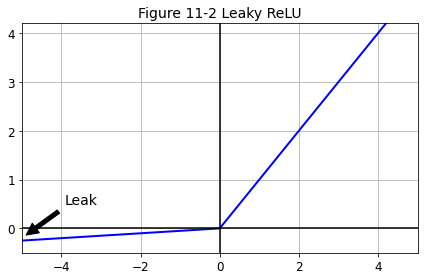

In [7]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Figure 11-2 Leaky ReLU", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

2015年由Djork-ArnéClevert等人撰写的论文。 提出了一种称为**指数线性单位 -  exponential linear unit（ELU）**的新激活函数，其在实验中的表现优于所有ReLU变体：训练时间减少，神经网络在测试集上表现更好。

它如图11-3所示即下图，公式11-2显示了它的定义。

公式 11-2 ELU激活函数：

$\mathrm{ELU}_{\alpha}(z)=\left\{\begin{array}{ll}\alpha(\exp (z)-1) & \text { if } z<0 \\ z & \text { if } z \geq 0\end{array}\right.$

In [8]:
def elu(z, alpha=1):
    return np.where(z< 0 ,alpha*(np.exp(z) -1), z )

Saving figure elu_plot


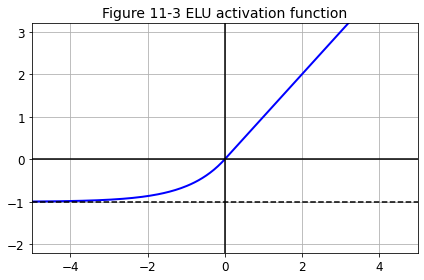

In [9]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"Figure 11-3 ELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

它看起来很像ReLU功能，但有一些主要区别：

* 首先，当z <0时，它采用负值，这允许该单位的平均输出接近0。如前所述，这**有助于缓解消失的梯度问题**。超参数 $ α$定义当 $z$ 是大负数时ELU函数接近的值。 它通常设置为1，但如果你愿意，可以像任何其他超参数一样调整它。

* 其次，它对于 $z <0 $具有非零梯度，这避免了死亡单位的问题。

* 第三，函数在任何地方都是平滑的，包括z = 0左右，这有助于加速梯度下降，因为它不会在z = 0的左右反弹。

**ELU激活功能的主要缺点**是它的计算速度比ReLU及其变量慢（由于使用了指数函数），但在训练期间，这可以通过更快的收敛速度得到补偿。但是，在测试时，ELU网络将比ReLU网络慢。

在2017年的一篇论文中， Günter Klambauer 等人提出了`Self-Normalizing`神经网络。 作者表明，如果你建立一个完全由稠密层组成的神经网络，并且如果所有的隐藏层都使用**SELU激活函数（顾名思义，它只是ELU激活函数的一个缩放版本）**。那么网络将自归一化：在训练过程中，每层的输出将趋向于保留均值0和标准差1，这就解决了消失/爆炸梯度问题。因此，对于这类神经网络（尤其是深度神经网络）来说，这种激活函数的性能往往非常显著地优于其他的激活函数。

但是，产生自归一化需要以下几个条件：
* 输入特征必须标准化（平均值为0，标准差为1）。
* 每个隐藏层的权重也必须使用`LeCun Normal`初始化。在Keras中，
这意味着使用`kernel_initializer = "lecun_normal"`。
* 网络的架构必须是顺序的。不幸的是，如果你试图在非顺序架构中使用SELU，
例如循环网络或具有跳转连接的网络(即跳过层的连接)，自归一化将无法保证，
因此SELU不一定会优于其他激活函数。
* 本文只在所有层都很密集的情况下保证自正化。然而，在实践中，SELU激活函数似乎对卷积神经网也很有效（见第14章）。

那么你的深度神经网络的隐藏层应该使用哪种激活函数呢？一般来说，SELU > ELU > Leaky ReLU（及其变体）> ReLU > tanh > logistic。如果网络的架构阻止了它的自归一化，那么ELU可能会比SELU表现得更好（因为SELU在z=0时不平滑）。如果你很在意运行时延迟，那么你可能会更喜欢Leaky ReLU。如果你不想再调整另一个超参数，您可以只使用Keras使用的默认α值（例如，0.3用于Leaky ReLU）。如果你有多余的时间和计算能力，你可以使用交叉验证来评估其他激活函数，特别是RReLU，如果你的网络过拟合，或者PReLU，当你有一个巨大的训练集。

当你想使用Leaky ReLU激活函数时，你必须生成一个LeakyReLU实例：

In [10]:
leaky_relu = keras.layers.LeakyReLU(alpha = 0.2)
layer = keras.layers.Dense(10, activation = leaky_relu,
                          kernel_initializer = "he_normal")

对于PReLU，只需用PReLU()替换LeakyRelu(alpha=0.2)即可。目前在Keras中还没有正式的RReLU实现，但是你可以相当容易地实现您自己的RReLU（参见第12章末尾的练习）。

对于SELU，只需要令`activation = "selu"`和`kernel_initializer="lecun_normal`即可：

In [11]:
layer = keras.layers.Dense(10, activation = "selu",
                          kernel_initializer = "lecun_normal")

### 11.1.3 Batch Normalization

虽然在使用ELU（或ReLU的任何变体）的同时使用He初始化可以显著减少训练初期的消失/爆炸梯度问题，但并不能保证在训练中不会再出现。

在2015年的一篇论文中，Sergey Ioffe和Christian Szegedy提出了一种名为Batch Normalization（BN）的技术来解决消失/爆炸梯度问题。该技术包括在模型中增加一个操作，
* 在每个隐藏层的激活函数之前或之后，简单地对每个输入进行**零中心化和归一化**，
* 然后用每个层的两个新参数向量对结果进行**缩放和移位**：一个用于缩放，另一个用于移位。

换句话说，这个操作让模型学习每层输入的最佳尺度和平均值。在许多情况下，如果你添加一个BN层作为神经网络的第一层，你不需要对你的训练集进行标准化（例如，使用StandardScaler）：BN层将为你做这件事（好吧，大约是这样，因为它每次只看一个批次，而且它还可以重新缩放和移动每个输入特征）。

为了对输入进行零中心和归一化，该算法需要估计每个输入的平均值和标准差。它通过评估每个输入在当前小批量上的平均值和标准差来实现（因此被称为 "批量归一化"）。整个操作过程总结在公式11-3中。

公式 11-3 批量归一化算法

1. $\quad \mu_{B}=\frac{1}{m_{B}} \sum_{i=1}^{m} \mathbf{x}^{(i)}$
2. $\quad \sigma_{B}^{2}=\frac{1}{m_{B}} \sum_{i=1}^{m}\left(\mathbf{x}^{(i)}-\mathbf{\mu}_{B}\right)^{2}$
3. $\quad \widehat{\mathbf{x}}^{(i)}=\frac{\mathbf{x}^{(i)}-\mu_{B}}{\sqrt{\sigma_{B}^{2}+\epsilon}}$
4. $\quad \mathbf{z}^{(i)}=\gamma \otimes \widehat{\mathbf{x}}^{(i)}+\beta$


* $\quad \mu_{B}$表示为输入的均值向量，对整个小批量$B$进行评估。
* $\quad \sigma_{B}$是输入标准差的向量，也是对整个小批量$B$进行评估。
* ${m_{B}}$表示`mini-batch`中实例的数量。
* $\quad \widehat{\mathbf{x}}^{(i)}$表示实例$i$经过0均值和归一化后的向量。
* $\otimes$表示逐元素相乘。
* $\beta$是该层的输出移位（偏移）参数向量（它包含每个输入的一个偏移参数）。每个输入都有相应的偏移参数。
* $\epsilon$是一个非常小的数，主要是为了避免除数为0，被称为平滑项。
* $\quad \mathbf{z}^{(i)}$表示BN操作的输出，它是输入的重新缩放和移位版本。

在测试时，没有小批量来计算经验均值和标准差，所以你需要使用整个训练集的均值和标准差。这些通常在训练期间使用移动平均值有效地计算。因此，总共为每个批量标准化层学习了四个参数：$γ$（输出规模向量，缩放），$β$（输出偏移向量，偏移），$μ$（最终输入均值向量，平均值）和
$σ$（最终输出标准差向量，标准偏差）$。注意，μ和σ是在训练过程中估计出来的，但它们在训练过程中完全不用，只是在训练后才使用（用来替换公式11-3中的批输入均值和标准差）。

作者证明了这项技术大大改善了他们实验过的所有深度神经网络。
* 梯度消失的问题大大减少了，他们可以使用饱和激活函数，例如tanh甚至逻辑激活函数。

* 网络对权重初始化也不太敏感。他们能够使用更高的学习率，显着加快学习过程

* 最后，就像一个不断给予的礼物，批量标准化也像正则化器一样，减少了对其他正则化技术的需求（例如本章后面描述的dropout）

但是，
* 批量标准化确实会给模型增加一些复杂性（虽然它不需要对输入数据进行标准化，因为第一个隐藏层会处理它，提供给它的是批量标准化的）。

* 此外，还有一个运行时间的惩罚：由于每层需要额外的计算，神经网络的预测速度较慢。



因此，**如果你需要快速预测，你可能需要在使用批量标准化之前检查普通 ELU + He 初始化的执行情况**。

你可能会发现训练速度相当慢，因为当你使用批归一化时，每个epoch需要更多的时间。然而，这通常会被以下事实所抵消：使用 BN 时收敛速度更快，因此需要更少的 epochs 才能达到相同的性能。总而言之，整体时间通常会更小。

####  Implementing Batch Normalization with Keras

与Keras的大多数事情一样，实现批次归一化非常简单。只需要在每一个隐藏层的激活函数之前之前添加`BatchNormalization`层即可。也可以有选择地在模型的第一层添加BN层：

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300,activation = "elu",kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100,activation = "elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

我们再放大一下。如果你显示模型摘要，你可以看到每个BN层每次输入都会增加4个参数：γ、β、μ和σ（例如，第一个BN层增加了3136个参数，是784的4倍）。最后两个参数μ和σ是移动平均数，它们不受反向传播的影响，所以Keras称它们为 "Nontrainable "（如果算上BN参数的总数，3136+1200+400，除以2，得到2368个，这就是这个模型中不可训练的参数总数）。

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1

我们来看看第一层BN的参数。两个是可训练的（通过backprop），两个是不可训练的。

In [14]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

现在，当你在Keras中创建一个BN层时，它还创建了两个操作，这些操作将在训练期间的每次迭代中被Keras调用。这些操作将更新移动平均数：

In [15]:
model.layers[1].updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

BN论文的作者主张在激活函数之前添加BN层，而不是在激活函数之后添加（就像我们刚才做的那样）。关于这一点有一些争论，因为**它似乎取决于任务**。因此，这是你可以实验的另一件事，看看哪个选项在你的数据集上效果最好。为了在激活函数之前添加BN层，我们必须从隐藏层中移除激活函数，并将其作为单独的层添加到BN层之后。此外，由于批次归一化层每个输入都包含一个偏移参数，所以你可以从前面的层中移除偏移项（只需在创建它时传递use_bias=False）。

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300,activation = "elu",kernel_initializer="he_normal",use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100,activation = "elu", kernel_initializer="he_normal",use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

BatchNormalization 类有很多超参数可以调整。默认值通常都很好，但您可能偶尔需要调整动量。该超参数在更新指数移动平均线时使用：给定一个新的值 v（即在当前批次中计算的新的输入均值或标准差向量），使用以下公式更新运行平均线：

$\widehat{\mathbf{v}} \leftarrow \widehat{\mathbf{v}} \times$ momentum $+\mathbf{v} \times(1-$ momentum $)$

momentum值通常很接近1。

另一个重要的超参数是 axis：它决定了哪个轴应该被归一化。它的默认值为-1，这意味着默认情况下，它将对最后一个轴进行归一化（使用在其他轴上计算的平均值和标准差）。例如，当输入的批次为 2D 时（即批次形状为 [batch size，features]），这意味着每个输入特征将根据批次中所有实例的平均值和标准差计算进行归一化。

请注意，BN层在训练期间和训练后进行的计算并不相同：它在训练期间使用批量统计，而在训练后使用 "最终 "统计（即移动平均数的最终值）。让我们来看看这个类的源码，看看是如何处理的:

In [17]:
# 示例代码，无法运行
class BatchNormalization(Layer):
    [...]
    def call(self, inputs, training = None):
        if training is None:
            training = keras.backend.learning_phase()

NameError: name 'Layer' is not defined

call()方法是实际执行计算的方法，正如你所看到的，它有一个额外的训练参数：如果它是None，它就会回落到keras.back end.learning_phase()，它在训练期间返回1（fit()方法确保了这一点）。如果你需要写一个自定义层，并且它需要在训练和测试期间有不同的行为，只需使用相同的模式即可（我们将在第12章讨论自定义层）。

批量归一化（Batch Normalization）已经成为深度神经网络中使用最多的层之一，以至于在图中经常被省略，因为人们认为BN是在每一层之后添加的。然而，张宏毅等人最近的一篇论文很可能会改变这种情况：作者展示了通过使用一种新颖的固定更新（fixed-up）权重初始化技术，他们设法在没有BN的情况下训练一个非常深的神经网络（10000层！），在复杂的图像分类任务上实现了最先进的性能。

### 11.1.4 Gradient Clipping

另一种减少梯度爆炸问题的流行技术是在反向传播过程中简单地剪辑梯度，使它们永远不会超过某个阈值。这就是所谓的梯度裁剪。这一技术通常使用在循环神经网络当中，因为批量归一化难以在循环神经网络中难以使用。

在Keras当中，使用梯度裁剪只需要在创建优化器时，设置`clipvalue`或`clipnorm`：

In [18]:
optimizer = keras.optimizers.SGD(clipvalue = 1.0)
model.compile(loss="mse",optimizer = optimizer)

这将把梯度向量的每一个分量裁剪到-1.0和1.0之间。这意味着所有损失的偏导数（关于每一个可训练参数）都将被剪切在-1.0和1.0之间。阈值是一个你可以调整的超参数。
* 请注意，它可能会改变梯度向量的方向：例如，如果原始梯度向量是[0.9，100.0]，它主要指向第二轴的方向，但一旦你按值剪裁它，就会得到[0.9，1.0]，它大致指向两轴之间的对角线。不过在实际操作中，这种方法很好用。
* 如果你想确保梯度裁剪不会改变梯度向量的方向，你应该通过设置clipnorm而不是clipvalue来按规范进行裁剪。如果梯度矢量的ℓ2规范大于你所选的阈值，这将会剪断整个梯度。例如，如果设置 clipnorm=1.0，那么向量 [0.9, 100.0] 将会被剪裁成 [0.00899964, 0.9999595]，保留其方向，但几乎消除了第一个分量。如果你观察到在训练过程中梯度会爆炸（你可以使用 TensorBoard 跟踪梯度的大小），你可能想尝试按值剪裁和按规范剪裁，并采用不同的阈值，看看哪个选项在验证集上表现最好。

## 11.2 Reusing Pretrained Layers

一般来说，**从头开始训练一个非常大的DNN并不是一个好主意**：相反，你应该总是尝试找到一个现有的神经网络，它能完成与你要解决的任务类似的任务（我们将在第14章讨论如何找到它们），然后只需重用这个网络的低层：这被称为迁移学习。这不仅会大大加快训练速度，而且需要的训练数据也会少很多。

例如，假设你可以使用一个DNN，该DNN经过训练可以将图片分为100个不同的类别，包括动物、植物、车辆和日常物体。你现在想训练一个DNN来对特定类型的车辆进行分类。这些任务非常相似，甚至部分重叠，所以你应该尝试重用第一个网络的部分内容（见图11-4）。

![image-20200823215235631](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/23/215247-370052.png)

>如果你的新任务的输入图片与原任务中使用的图片尺寸不一样，你通常要**增加一个预处理步骤，将它们调整到原模型预期的尺寸**。更一般来说，当输入具有类似的低级特征时，迁移学习将发挥最佳效果。


* 原有模型的输出层通常应该被替换，因为它很可能对新的任务一点用处都没有，甚至可能连新任务的输出数量都不合适。

* 同样，原始模型的上层隐藏层也不可能像下层一样有用，因为对新任务最有用的高层特征可能与对原始任务最有用的特征有很大不同。你要找到合适的层数来重用。

* 任务越相似，你想要重用的层数越多（从低层开始）。对于非常相似的任务，你可以尝试保留所有的隐藏层，只替换输出层。

### 11.2.1 Transfer Learning With Keras

假设流行的MNIST数据集**只包含8个类**，例如除了凉鞋和衬衫之外的所有类。有人在该数据集上建立并训练了一个Keras模型，并获得了相当不错的性能（准确率>90%）。现在你想解决一个不同的任务：你有凉鞋和衬衫的图像，你想训练一个二元分类器（正向=衬衫，负向=凉鞋）。然而，你的数据集相当小，你只有200张标签图像。当你为这个任务训练了一个新的模型（我们称它为模型B），其架构与模型A相同，它的表现相当不错（97.2%的准确率），但由于这是一个更简单的任务（只有2个类），你希望能有更多的结果。在喝早上咖啡的时候，你发现你的任务和任务A很相似，也许转移学习可以帮助你呢? 让我们一探究竟吧! 

In [19]:
# 下载MINIST数据集
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [20]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [21]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [22]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

# 只包含8个类，需要对数据进行清洗
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [23]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 3s 77us/sample - loss: 0.5470 - accuracy: 0.8236 - val_loss: 0.3874 - val_accuracy: 0.8700
Epoch 2/20
43986/43986 [==============================] - 3s 63us/sample - loss: 0.3602 - accuracy: 0.8746 - val_loss: 0.3356 - val_accuracy: 0.8844
Epoch 3/20
43986/43986 [==============================] - 3s 67us/sample - loss: 0.3245 - accuracy: 0.8865 - val_loss: 0.3096 - val_accuracy: 0.8941
Epoch 4/20
43986/43986 [==============================] - 3s 65us/sample - loss: 0.3052 - accuracy: 0.8925 - val_loss: 0.2968 - val_accuracy: 0.8969
Epoch 5/20
43986/43986 [==============================] - 3s 65us/sample - loss: 0.2918 - accuracy: 0.8975 - val_loss: 0.2889 - val_accuracy: 0.9028
Epoch 6/20
43986/43986 [==============================] - 3s 59us/sample - loss: 0.2817 - accuracy: 0.9024 - val_loss: 0.2770 - val_accuracy: 0.9051
Epoch 7/20
43986/43986 [==============================] -

In [24]:
model_A.save("my_model_A.h5")

首先，你需要加载模型A，并根据模型A的图层创建一个新的模型。让我们重用除了输出层以外的所有层;

In [25]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")) # 增加一层

注意，model_A和model_B_on_A现在共享一些层。**当你训练model_B_on_A时，它也会影响model_A**。如果你想避免这种情况，你需要在重用其层之前克隆model_A。要做到这一点，你必须克隆模型A的架构，然后复制它的权重（因为clone_model()不会克隆权重）。

In [26]:
model_A_clone = keras.models.clone_model(model_A)  # 克隆模型
model_A_clone.set_weights(model_A.get_weights())    # 克隆权重

现在我们可以直接为任务B训练model_B_on_A，但是由于新的输出层是随机初始化的，所以至少在前几个epochs期间会有很大的误差，所以会有很大的误差梯度，可能会破坏重用的权重。为了避免这种情况，一种方法是在前几个epochs期间冻结重用层，给新层一些时间来学习合理的权重。要做到这一点，只需将每个层的训练能力属性设置为False，然后编译模型：

In [27]:
for layer in model_B_on_A.layers[:-1]: # 冻结最后一层之外的所有层
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

接下来，我们可以对模型进行几个epoch的训练，然后解冻重用层（这需要再次编译模型），继续训练，对任务B的重用层进行微调，解冻重用层后，通常会降低学习率，再次避免破坏重用权重。

In [28]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B)) # 冻结层训练

for layer in model_B_on_A.layers[:-1]:  # 解冻冻结的层，开始训练
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 3ms/sample - loss: 0.7186 - accuracy: 0.5900 - val_loss: 0.6525 - val_accuracy: 0.6187
Epoch 2/4
200/200 [==============================] - 0s 304us/sample - loss: 0.6638 - accuracy: 0.6400 - val_loss: 0.6047 - val_accuracy: 0.6552
Epoch 3/4
200/200 [==============================] - 0s 304us/sample - loss: 0.6164 - accuracy: 0.6550 - val_loss: 0.5619 - val_accuracy: 0.6917
Epoch 4/4
200/200 [==============================] - 0s 309us/sample - loss: 0.5738 - accuracy: 0.7050 - val_loss: 0.5235 - val_accuracy: 0.7181
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 3ms/sample - loss: 0.4726 - accuracy: 0.7950 - val_loss: 0.3450 - val_accuracy: 0.8692
Epoch 2/16
200/200 [==============================] - 0s 324us/sample - loss: 0.3287 - accuracy: 0.8750 - val_loss: 0.2574 - val_accuracy: 0.9341
Epoch 3/16
200/200 [====================

In [29]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06132340602576733, 0.9915]

你相信吗？你不应该是。我作弊了！:) 我尝试了许多配置，直到我找到了一个表现出强大改进的配置。如果你试着改变类或随机种子，你会发现改进通常会下降，甚至消失或逆转。我所做的事情叫做 "折磨数据，直到它认罪"。当一篇论文只是看起来太积极的时候，你应该怀疑：也许华而不实的新技术并没有什么帮助（事实上，它甚至可能会降低性能），但作者尝试了许多变体，只报告了最好的结果（这可能是由于纯粹的运气），而没有提到他们在路上遇到了多少失败。大多数情况下，这根本不是恶意的，但这也是《科学》杂志上许多结果永远无法重现的部分原因

In [30]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid")) # 新的网络，没有使用迁移学习

In [31]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [32]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))  # 结果与使用迁移学习的网络进行对比

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 3ms/sample - loss: 0.7381 - accuracy: 0.5750 - val_loss: 0.6279 - val_accuracy: 0.6856
Epoch 2/20
200/200 [==============================] - 0s 329us/sample - loss: 0.5054 - accuracy: 0.7700 - val_loss: 0.4673 - val_accuracy: 0.8215
Epoch 3/20
200/200 [==============================] - 0s 334us/sample - loss: 0.3688 - accuracy: 0.9000 - val_loss: 0.3714 - val_accuracy: 0.8773
Epoch 4/20
200/200 [==============================] - 0s 394us/sample - loss: 0.2892 - accuracy: 0.9550 - val_loss: 0.3087 - val_accuracy: 0.9128
Epoch 5/20
200/200 [==============================] - 0s 349us/sample - loss: 0.2372 - accuracy: 0.9650 - val_loss: 0.2638 - val_accuracy: 0.9381
Epoch 6/20
200/200 [==============================] - 0s 334us/sample - loss: 0.1999 - accuracy: 0.9650 - val_loss: 0.2331 - val_accuracy: 0.9493
Epoch 7/20
200/200 [==============================] - 0s 329us/sample - loss: 0.

In [33]:
model_B.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.09481127923727035, 0.9835]

那么我为什么要作弊呢？好吧，事实证明，迁移学习对小密度网络的效果并不好：它对深度卷积神经网络的效果最好，所以我们将在第14章中使用同样的技术重新讨论转移学习（这次不会有作弊，我保证！）。

### 11.2.2 Unsupervised Pretraining 

假设你想处理一个复杂的任务，**你没有太多标签化的训练数据**，但不幸的是你**找不到一个在类似任务上训练的模型**。不要失去所有的希望! 首先，你当然应该尝试收集更多的标签化训练数据，但如果这太难或太贵，你可能还可以进行无监督的预训练（见图11-5）。收集未标记的训练实例通常相当便宜，但标记它们却相当昂贵。如果你能收集到大量未标记的训练数据，你可以尝试逐层训练，从最低层开始，然后向上，使用无监督的特征检测器算法，如限制性玻尔兹曼机(RBMs)或自动编码器。每个层都是在之前训练过的层的输出上进行训练的（除了正在训练的层之外，所有的层都被冻结）。一旦所有的层都被这样训练过，你就可以为你的任务添加输出层，并使用监督学习（即使用标记的训练例子）对最终的网络进行微调。此时，你可以解冻所有的预训练层，或者只解冻部分上层。

![image-20200824161350345](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/24/161352-189245.png)

这是一个相当漫长而繁琐的过程，但往往效果不错。

### 11.2.3 Pretraining on a Auxiliary Task

如果你没有太多标签化的训练数据，最后一个选择是**在一个辅助任务上训练第一个神经网络**，你可以很容易地获得或生成标签化的训练数据，然后在实际任务中重用该网络的下层。**第一个神经网络的下层将学习特征检测器，这些特征检测器很可能会被第二个神经网络重用**。

* 例如，如果你想建立一个识别人脸的系统，你可能只有每个人的几张照片--显然不足以训练一个好的分类器。收集每个人的数百张照片并不实用。然而，你可以在网络上随机收集很多人的照片，然后训练第一个神经网络来检测两张不同的照片是否具有同一个人的特征。这样的网络会学习到很好的人脸特征检测器，所以重用它的下层可以让你用很少的训练数据训练出一个好的人脸分类器。

* 对于自然语言处理(NLP)应用，你可以轻松下载数百万个文本文档，并从中自动生成标签数据。例如，你可以随机屏蔽掉一些单词，然后训练一个模型来预测缺失的单词是什么（例如，它应该预测 "你说的是什么__？"句子中缺失的单词可能是 "are "或 "were"）。如果你能训练一个模型在这个任务上达到很好的性能，那么它已经对语言有相当多的了解，你当然可以在你的实际任务中重用它，并在你的标签数据上对它进行微调。

> 自监督学习是指你从数据本身自动生成标签，然后使用监督学习技术在生成的 "标签 "数据集上训练模型。由于这种方法不需要人为标注，所以最好将其归为无监督学习的一种形式。

## 11.3 Faster Optimizers

### 11.3.1 Momentum Optimization

想象一下，一个保龄球在光滑的表面上沿着缓坡滚动：它开始时速度很慢，但很快就会增加动量，直到最终达到极限速度（如果有一些摩擦或空气阻力的话）。这就是1964年鲍里斯-波利亚克（Boris Polyak）提出的 "动量优化 "背后的非常简单的思想。相比之下，**普通的Gradient Descent并不关心之前的梯度是多少。如果局部的梯度很小，它就会走得很慢。**。

动量优化非常关心之前的梯度是什么：在每次迭代时，它从动量向量m（乘以学习率η）中减去局部梯度，并通过简单地添加这个动量向量来更新权重（见公式11-4）。换句话说，梯度是用于加速度，而不是用于速度。为了模拟某种摩擦机制，防止动量增长过大，算法引入了一个新的超参数β，简称为动量，它必须设置在0（高摩擦）和1（无摩擦）之间。典型的动量值是0.9。

公式 11-4 Momentum 算法：

1. $\mathbf{m} \leftarrow \beta \mathbf{m}-\eta \nabla_{\theta} J(\boldsymbol{\theta})$
2. $\quad \theta \leftarrow \theta+\mathbf{m}$

你可以很容易地验证，如果梯度保持不变，则最终速度（即权重更新的最大尺寸 )与梯度和学习率$\eta$、$\frac{1}{1-\beta}$的积相等。若$\beta = 0.9$，最终的速度是梯度与学习率乘积的10倍，所以动量优化最后要比梯度下降快10倍! 这使得**动量优化能够比梯度下降更快地摆脱高原**。

动量优化会越来越快地滚下谷底，直到到达谷底（最优）。在不使用批次归一化的深度神经网络中，上层经常会出现尺度非常不同的输入，所以使用动量优化会有很大帮助。**它还可以帮助跳出局部最优值**。

由于动量的作用，优化器可能会超调一点，然后回来，再超调，在稳定在最小值之前，这样振荡很多次。这也是为什么系统中有一点摩擦力是好的原因之一：它可以摆脱这些振荡，从而加快收敛速度。

In [35]:
# 在Keras中实现动量优化只需使用SGD优化器并设置其动量超参数，
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

>动量优化的缺点是引入了新的需要微调的超参数。

### 11.3.2 Nesterov Accelerated Gradient 

**Nesterov加速梯度**是Momentum优化的一个小变种，由Yurii Nesterov于1983年提出，几乎总是比vanilla 动量优化更快。Nesterov 动量优化或Nesterov Accelerated Gradient（NAG）的思想是**测量成本函数的梯度，而不是在局部位置，而是在动量方向略微向前（见公式11-5）**。**与 vanilla 动量优化的唯一区别是梯度是在$θ+βm$而不是$θ$处测量的**。

公式 11-5 Nesterov Accelerated Gradient算法

1. $\quad \mathbf{m} \leftarrow \beta \mathbf{m}-\eta \nabla_{\theta} J(\boldsymbol{\theta}+\beta \mathbf{m})$
2. $\quad \theta \leftarrow \theta+\mathrm{m}$

这个小调整是有效的，因为通常动量矢量将指向正确的方向（即朝向最佳方向），所以使用在该方向上稍微测量一点的梯度而不是在原始位置使用梯度会稍微准确一些，如图11-6所示（其中$∇_1$表示在此处测量的成本函数的梯度）起点$θ$，$∇_2$ 表示位于 $θ+βm$ 点处的梯度。

![image-20200824164724767](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/24/164726-27716.png)

NAG 与常规动量优化相比，几乎总能加快训练速度。要使用它，**只需在创建 MomentumOptimizer 时设置 `use_nesterov = True`**

In [36]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad

再次考虑细长的碗问题：

梯度下降开始于快速下降到最陡的斜坡，然后缓慢下降到山谷的底部。如果算法能够及早发现并纠正其方向以指向全局最优点，那将是很好的。

**AdaGrad算法**通过沿最陡的尺寸缩小梯度向量来实现这一点（见公式11-6）：

公式 11-6 AdaGrad 算法

1. $\cdot \quad \mathbf{s} \leftarrow \mathbf{s}+\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta}) \otimes \nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$
2. $\quad \theta \leftarrow \theta-\eta \nabla_{\theta} J(\theta) \oslash \sqrt{s+\epsilon}$

* **第一步将梯度的平方累积到向量 $s$ 中**（⊗符号表示元素乘法）。该矢量化形式相当于对矢量 $s$ 的每个元素 $s_i$ 计算$s_i←s_i +(∂/∂θ_iJ(θ))^2$;换句话说，每个 $s_i$ 累加关于参数 $θ_i$ 的代价函数的偏导数的平方。如果成本函数沿着第 $i$ 维度陡峭，那么 $s_i$ 将在每次迭代时变得越来越大。


* **第二步几乎与Gradient Descent相同，但有一个很大的区别**：梯度向量按比例缩小\sqrt[2]{s + ε}（⊘符号表示逐元素除法，$ε$是平滑项，以避免除以零，通常设置为$10^{ -10}$）。该矢量化形式相当于计算所有参数$θ_i$（同时）的
$θ_i \leftarrow θ_i-η∂/∂θ_iJ(θ)/ \sqrt[2]{s_i + ε} $。


简而言之，这种算法会降低学习率，**but it does so faster for steep dimensions than for dimensions with gentler slopes.**。这被称为**自适应学习率**。它有助于 
* 将结果更新更直接地指向全局最优（见图11-7）。
* 另一个好处是它需要更少的学习速率超参数$η$的调整。

![image-20200824170012417](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/24/170015-994224.png)

对于简单的二次问题，AdaGrad经常表现良好。但不幸的是，**它在训练神经网络时经常停止得太早。学习速率大大缩小，以至于算法在达到全局最优之前最终完全停止**。因此，**尽管TensorFlow具有AdagradOptimizer，但你不应该使用它来训练深度神经网络**（尽管可能对诸如线性回归之类的简单任务有效）。

In [37]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

### 11.3.4 RMSProp

尽管AdaGrad的速度有点过快，但最终还是没有收敛到全局最优，**RMSProp算法**仅通过累积来自最近迭代的梯度（与自训练开始以来的所有梯度相反）来修正这一缺点。它**通过在第一步中使用指数衰减来实现**（见公式11-7）。

公式 11-7 RMSProp 算法

1. $\mathbf{s} \leftarrow \beta \mathbf{s}+(1-\beta) \nabla_{\theta} J(\boldsymbol{\theta}) \otimes \nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$
2. $\quad \theta \leftarrow \theta-\eta \nabla_{\theta} J(\theta) \oslash \sqrt{s+\epsilon}$

**衰减率$β$通常设定为0.9**。 是的，它又是一个新的超参数，但是这个默认值通常效果很好，所以你可能根本不需要调整它。

正如你所料，TensorFlow有一个**RMSPropOptimizer类**：

In [38]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

**除了非常简单的问题，这个优化器几乎总是比AdaGrad好得多。** 它通常**也比Momentum优化和Nesterov Accelerated Gradients表现更好**。实际上，在Adam优化出现之前，它是许多研究人员首选的优化算法。

### 11.3.5 Adam and Nadam Optimization

**Adam，代表自适应矩估计，结合Momentum优化和RMSProp的想法**：
* 就像动量优化一样，它跟踪过去梯度的指数衰减平均值，
* 就像RMSProp一样，它跟踪过去平方梯度的指数衰减平均值（见公式11-8）。

公式 11-8 Adam 算法

1. $\quad \mathbf{m} \leftarrow \beta_{1} \mathbf{m}-\left(1-\beta_{1}\right) \nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$
2. $\quad \mathbf{s} \leftarrow \beta_{2} \mathbf{s}+\left(1-\beta_{2}\right) \nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta}) \otimes \nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$
3. $\quad \widehat{\mathrm{m}} \leftarrow \frac{\mathrm{m}}{1-\beta_{1}^{t}}$
4. $\quad \widehat{\mathbf{s}} \leftarrow \frac{\mathbf{s}}{1-\beta_{2}^{t}}$
5. $\quad \theta \leftarrow \theta+\eta \widehat{\mathrm{m}} \oslash \sqrt{\mathrm{s}+\epsilon}$

其中，$t$表示迭代次数，从1开始。

如果你只看第1步，第2步和第5步，你会发现Adam与动量优化和RMSProp这两者非常相似。**唯一的区别是步骤 1 计算指数衰减的平均值而不是指数衰减的和，但这些实际上是等效的，除了常数因子**（衰减平均值只是衰减总和的$1 - β_1$倍）。

步骤3和4在某种程度上是技术细节：由于 $m$ 和 $s$ 初始化为0，因此在训练开始时它们将偏向0，因此这两个步骤将有助于在训练开始时提升 $m$ 和 $s$ 。

* 动量衰减超参数 $β_1$ 通常初始化为0.9，
* 而缩放衰减超参数 $β2$ 通常初始化为0.999。 
* 平滑项$ε$通常初始化为一个很小的数字，如$10^{-7}$。

In [39]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

如果你开始对所有这些不同的技术感到不知所措，并想知道如何为你的任务选择合适的技术，不要担心：本章末尾提供了一些实用的指南：
* Adamax，与Adam在同一篇论文中引入：注意，在等式11-8的第2步中，Adam累积了s中梯度的平方（最近的权重较大）。在步骤5中，如果我们忽略ϵ和步骤3和步骤4（反正是技术细节），Adam只是用s的平方根来缩减参数更新，简而言之，Adam用时间衰减梯度的ℓ2规范来缩减参数更新（记得$ℓ_2$规范是平方和的平方根）。Adamax只是用$ℓ_∞$法则（一种花哨的说法，即最大法则）代替了$ℓ_2$法则。具体来说，它将公式11-8中的第2步替换成了 $\mathbf{s} \leftarrow \max \left(\beta_{2} \mathbf{s}, \nabla_{\theta} J(\theta)\right)$，放弃了第4步，而在第5步中，它将梯度更新的规模缩小了一个s的系数，也就是时间衰减梯度的最大值。在实践中，这可以使**Adamax比Adam更稳定，但这实际上取决于数据集**，一般来说，Adam实际上表现更好。所以，这只是多了一个优化器，如果你在某些任务上遇到Adam的问题，你可以尝试一下。

*  Nadam优化比较重要：它只是Adam优化加上Nesterov技巧，所以它的收敛速度往往会比Adam略快。Timothy Dozat在他的报告中比较了许多不同优化器在各种任务上的表现，发现Nadam的表现普遍优于Adam，但有时会被RMSProp超越。

迄今为止讨论的所有优化技术都只依赖于一阶偏导数（Jacobians）。优化文献中包含了基于二阶偏导数（Hessians，即Jacobians的偏导数）的惊人算法。不幸的是，这些算法很难应用于深度神经网络，因为每个输出有$n^2$个黑森（其中n是参数数），而每个输出只有n个Jacobians。DNN中的参数非常多，内存无法满足二阶优化算法。

**Training Sparse Models**

刚刚提出的所有优化算法都产生了密集的模型，这意味着大多数参数都是非零的。如果你在运行时需要一个超快的模型，或者如果你需要它来占用更少的内存，你可能更喜欢产生**稀疏模型**。

* 实现这一目标的一个很简单的方法是像往常一样训练模型，然后摆脱微小的权重（将它们设置为0）。但这很有可能使得模型的表现变差。

* 较好选择是在训练期间应用强 $ ℓ 1$ 正则化，因为它推动优化器将尽可能多的权重归零（如第4章中关于Lasso回归所讨论的那样）。


但是，在某些情况下，这些技术可能仍然不足。最好的选项是应用**双平均 - Dual Averaging**，通常称为**跟随正规化领导者 - Follow The Regularized Leader （FTRL）**，这是Yurii Nesterov提出的技术。

当与 $ ℓ 1$正则化一起使用时，这种技术通常会导致非常稀疏的模型。 TensorFlow在**FTRLOptimizer类**中实现了一个名为**FTRL-Proximal**的FTRL变体。

### 11.3.6 Learning Rate Scheduling

**学习率调度**

找到一个好的学习率可能会很棘手。 
* 如果你**设置得太高**，训练可能会发散（正如我们在第4章中讨论的那样）。

* 如果你将它**设置得太低**，训练最终会收敛到最佳状态，但这需要很长时间。

* 如果你把它**设置得有点太高**，它一开始会很快进展，但最终会在最优解附近振荡，永远不会安定下来（除非你使用自适应学习速率优化算法，如AdaGrad，RMSProp或Adam，但是即使这样，也许需要时间来解决）。

* 如果计算预算有限，则可能必须在正确收敛之前中断训练，从而产生次优解（见图11-8）。

![image-20200824193816531](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/24/193818-215869.png)

正如我们在第10章中所讨论的那样，一种方法是从一个大的学习率开始，然后将其除以3，直到训练算法停止发散。你不会离最佳学习率太远，它可以快速学习并收敛到良好的解决方案。

然而，你可以比恒定的学习率做得更好：如果你从高学习率开始，一旦停止快速进步，就降低学习率，你可以比使用最佳恒定学习率更快地达到一个好的解决方案。在训练过程中，有许多不同的策略来降低学习率。这些策略被称为学习计划（我们在第4章中简单介绍了这个概念），其中最常见的策略是：
* **Power scheduling** ：令学习率是迭代次数$t$的函数$\eta(t)=\eta_{0} /(1+t / s)^{c}$。学习率初始化为$\eta_{0}$，超参数为$c, s$。学习率每一步都在下降。

* **Exponential scheduling** : 令学习率为$\eta(t)=\eta_{0} {0.1}^{t/s}$，每隔s步，学习速度会逐渐下降10倍。比`Power scheduling`下降更快。

* **Piecewise constant scheduling** : 在若干个epoch中使用恒定的学习率（例如，$η_0$=0.1，5个纪元），然后在另一个纪元中使用较小的学习率（例如，$η_1$=0.001，50个纪元），以此类推。虽然这种解决方案可 以很好地工作，但通常需要摆弄很久以找出正确的学习率以及何时使用它们。

* **Performance scheduling** ：每N步测量一次验证错误（就像早期停止一样），并在错误停止时将学习速率降低$λ$倍

Andrew Senior等人2013年撰写的论文,**比较了使用动量优化训练深度神经网络进行语音识别时一些最流行的学习调度的表现**。作者得出结论，**在这种设置下，性能调度和指数调度都表现良好，但它们支持指数调度，因为它实现起来更简单，易于调优，并且可以更快地收敛到最优解**。 

在Keras中实现功率调度是最简单的选择：在创建优化器时设置衰减超参数即可。衰减是s的倒数（学习率再除以一个单位所需的步数），Keras假设c等于1：

**Power scheduling**

In [40]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

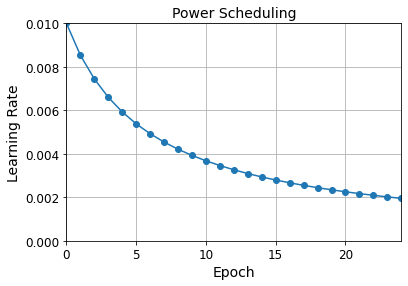

In [41]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
n_epochs = 25
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**Exponential scheduling**

Exponential scheduling和 piecewise scheduling也很简单。你首先需要定义一个函数，取当前的epoch并返回学习率:

In [42]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

如果你不想硬编码$η_0$和s，你可以创建一个函数，返回一个配置好的函数:

In [43]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s = 20)


In [44]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [46]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 94us/sample - loss: 0.8522 - accuracy: 0.7625 - val_loss: 1.0062 - val_accuracy: 0.7592
Epoch 2/25
55000/55000 [==============================] - 5s 83us/sample - loss: 0.7237 - accuracy: 0.7820 - val_loss: 0.6979 - val_accuracy: 0.8296
Epoch 3/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.6563 - accuracy: 0.8024 - val_loss: 0.8819 - val_accuracy: 0.7858
Epoch 4/25
55000/55000 [==============================] - 5s 85us/sample - loss: 0.5585 - accuracy: 0.8249 - val_loss: 0.6132 - val_accuracy: 0.8356
Epoch 5/25
55000/55000 [==============================] - 5s 87us/sample - loss: 0.4922 - accuracy: 0.8472 - val_loss: 0.5192 - val_accuracy: 0.8446
Epoch 6/25
55000/55000 [==============================] - 5s 85us/sample - loss: 0.4549 - accuracy: 0.8561 - val_loss: 0.6208 - val_accuracy: 0.8442
Epoch 7/25
55000/55000 [==============================] -

LearningRateScheduler会在每个epoch开始时更新优化器的learning_rate属性。通常每一次更新学习率就足够了，但如果你想更频繁地更新学习率，比如每一步都更新，你需要写自己的回调。如果每个epoch有很多步，这就有意义了。

In [47]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

In [48]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 注意:  `batch` 参数每个epoch都会重置 
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.8146 - accuracy: 0.7641 - val_loss: 0.7119 - val_accuracy: 0.7812
Epoch 2/25
55000/55000 [==============================] - 5s 94us/sample - loss: 0.6105 - accuracy: 0.8099 - val_loss: 0.6293 - val_accuracy: 0.7876
Epoch 3/25
55000/55000 [==============================] - 5s 98us/sample - loss: 0.5513 - accuracy: 0.8284 - val_loss: 0.6833 - val_accuracy: 0.7632
Epoch 4/25
55000/55000 [==============================] - 5s 94us/sample - loss: 0.5121 - accuracy: 0.8388 - val_loss: 0.6017 - val_accuracy: 0.8376
Epoch 5/25
55000/55000 [==============================] - 5s 95us/sample - loss: 0.4586 - accuracy: 0.8514 - val_loss: 0.4644 - val_accuracy: 0.8596
Epoch 6/25
55000/55000 [==============================] - 5s 94us/sample - loss: 0.4134 - accuracy: 0.8665 - val_loss: 0.5510 - val_accuracy: 0.8570
Epoch 7/25
55000/55000 [==============================] 

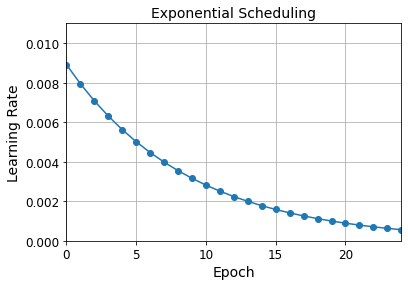

In [49]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

当你保存一个模型时，**优化器和它的学习率也会一起保存**。这意味着，有了这个新的schedule函数，你可以直接加载一个训练好的模型，然后在它离开的地方继续训练，没有问题。然而，如果你的schedule函数使用了epoch参数，事情就没那么简单了：事实上，epoch不会被保存，每次调用fit()方法时，它都会被重置为0。这可能会导致当你在模型离开的地方继续训练模型时，学习率非常大，这很可能会损坏你的模型的权重。一个解决方案是手动设置fit()方法的initial_epoch参数，使epoch从正确的值开始。

**piecewise constant**

你可以使用像下面这样的调度函数（和前面一样，如果你想的话，可以定义一个更通用的函数），然后用这个函数创建一个LearningRateScheduler回调，并把它传递给fit()方法，就像我们对指数调度所做的那样。

In [50]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [51]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [52]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 96us/sample - loss: 0.8547 - accuracy: 0.7538 - val_loss: 0.7413 - val_accuracy: 0.7598
Epoch 2/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.8804 - accuracy: 0.7373 - val_loss: 0.9049 - val_accuracy: 0.6680
Epoch 3/25
55000/55000 [==============================] - 5s 84us/sample - loss: 1.1207 - accuracy: 0.6340 - val_loss: 1.2532 - val_accuracy: 0.6070
Epoch 4/25
55000/55000 [==============================] - 5s 84us/sample - loss: 1.0984 - accuracy: 0.6280 - val_loss: 1.0609 - val_accuracy: 0.5740
Epoch 5/25
55000/55000 [==============================] - 5s 84us/sample - loss: 1.0674 - accuracy: 0.6228 - val_loss: 1.2699 - val_accuracy: 0.5842
Epoch 6/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.8336 - accuracy: 0.6678 - val_loss: 0.8808 - val_accuracy: 0.6658
Epoch 7/25
55000/55000 [==============================] -

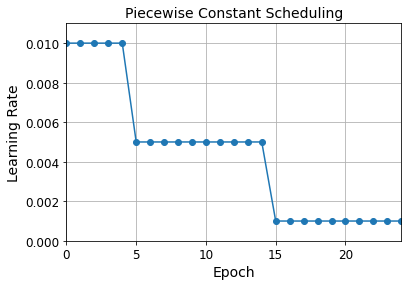

In [53]:

plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**Performance scheduling**

In [54]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 69us/sample - loss: 0.6002 - accuracy: 0.8032 - val_loss: 0.6012 - val_accuracy: 0.8202
Epoch 2/25
55000/55000 [==============================] - 4s 70us/sample - loss: 0.5236 - accuracy: 0.8346 - val_loss: 0.4712 - val_accuracy: 0.8456
Epoch 3/25
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5163 - accuracy: 0.8428 - val_loss: 0.5733 - val_accuracy: 0.8460
Epoch 4/25
55000/55000 [==============================] - 4s 65us/sample - loss: 0.5074 - accuracy: 0.8475 - val_loss: 0.6193 - val_accuracy: 0.8072
Epoch 5/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.4985 - accuracy: 0.8522 - val_loss: 0.5068 - val_accuracy: 0.8614
Epoch 6/25
55000/55000 [==============================] - 4s 66us/sample - loss: 0.5071 - accuracy: 0.8549 - val_loss: 0.6087 - val_accuracy: 0.8484
Epoch 7/25
55000/55000 [==============================] -

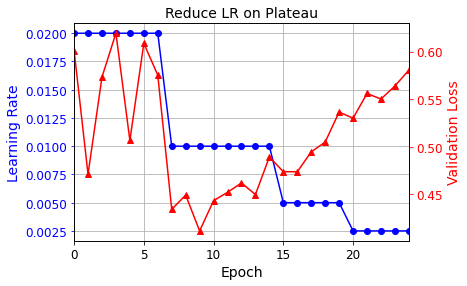

In [55]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

最后，tf.keras提供了另一种实现学习率调度的方法：只需使用`keras.optimizers.schedules`即可。然后将这个学习率传递给任何优化器。这种方法在每一步更新学习率，而不是在每一个epoch更新学习率。例如，这里是如何实现与前面相同的指数时间表:

In [56]:
s = 20 * len(X_train) 
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1) 
optimizer = keras.optimizers.SGD(learning_rate) 

In [57]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [58]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 72us/sample - loss: 0.4931 - accuracy: 0.8277 - val_loss: 0.4212 - val_accuracy: 0.8570
Epoch 2/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3811 - accuracy: 0.8653 - val_loss: 0.3942 - val_accuracy: 0.8624
Epoch 3/25
55000/55000 [==============================] - 3s 57us/sample - loss: 0.3461 - accuracy: 0.8762 - val_loss: 0.3697 - val_accuracy: 0.8726
Epoch 4/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3233 - accuracy: 0.8854 - val_loss: 0.3564 - val_accuracy: 0.8770
Epoch 5/25
55000/55000 [==============================] - 3s 60us/sample - loss: 0.3039 - accuracy: 0.8908 - val_loss: 0.3452 - val_accuracy: 0.8790
Epoch 6/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.2901 - accuracy: 0.8948 - val_loss: 0.3489 - val_accuracy: 0.8784
Epoch 7/25
55000/55000 [==============================] -

## 11.4  Aboiding Overfitting Through Regularization

深度神经网络通常有数万个参数，有时甚至有数百万个。有了这么多的参数，网络就有了惊人的自由度，可以适应各种各样的复杂数据集。但这种巨大的灵活性也意味着它容易对训练集进行过度拟合。我们需要正则化。

我们在第10章中已经实现了一个最好的正则化技术：提前停止。此外，尽管Batch Normalization 是为了解决消失/爆炸梯度问题而设计的，但它也是一个非常好的正则化器。在这一节中，我们将介绍其他流行的神经网络正则化技术：ℓ1和ℓ2正则化、dropout和max-norm正则化。

### 11.4.1 ℓ1and ℓ2 Regularization

就像你在第4章中对简单线性模型所做的那样，你可以使用 $ℓ1$ 和 $ℓ2$ 正则化来约束神经网络的连接权重（但通常不是偏置）。对Keras层的连接权重使用正则化系数为0.01的$ℓ2$正则化：

In [59]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

`le()`函数会返回一个正则化器，这个正则化器会被调用，用于在训练的每一步计算正则化损失。这个损失会被添加进最终的损失。如你所想，你可以使用`keras.regulizers.l()`进行$ℓ1$正则化。而如果你想同时使用$ℓ1$ 和 $ℓ2$ 正则化，你可以使用`keras.regulizersl1_l2()`（需要同时指定两个正则化系数）。

由于你通常希望对网络中的所有层应用相同的正则化器，以及在所有隐藏层中应用相同的激活函数和相同的初始化策略，你可能会发现自己在不断重复相同的参数。这使得它变得丑陋且容易出错。为了避免这种情况，你可以尝试重构你的代码来使用循环。另一个选择是使用 Python 的 functools.partial() 函数：它可以让你为任何可调用的代码创建一个薄的包装，并提供一些默认的参数值。例如，你可以使用：

In [60]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 6s 100us/sample - loss: 1.6691 - accuracy: 0.8117 - val_loss: 0.7271 - val_accuracy: 0.8270
Epoch 2/2
55000/55000 [==============================] - 5s 85us/sample - loss: 0.7185 - accuracy: 0.8280 - val_loss: 0.7107 - val_accuracy: 0.8306


### 11.4.2 Dropout

最流行的深度神经网络正则化技术可以说是**dropout**。它由G. E. Hinton于2012年提出，并在Nitish Srivastava等人的论文中进一步详述，事实证明它非常成功：即使是最先进的神经网络，只需添加dropout，就可以提高1-2％的准确度。这可能听起来不是很多，但是**当模型已经具有95％的准确度时，获得2％的准确度提升意味着将错误率降低近40％（从5％误差变为大约3％）**。


这是一个相当简单的算法：
* 在每个训练步骤中，每个神经元（包括输入神经元但不包括输出神经元）都有一个暂时“退出”的概率 **p**，这意味着在此训练步骤中它将被完全忽略，但在下一步中它可能是活动的（见图11-9） 。

* 超参数 **p** 称为**丢失率 - dropout rate**，通常设置为50％。训练后，神经元不再被丢弃。
![image-20200825111323781](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/25/111325-611389.png)

起初这个相当野蛮的技术起作用是非常令人惊讶的。如果员工被告知每天早上扔硬币来决定是否去上班，公司会表现得更好吗？嗯，谁知道呢;也许它会！
* 该公司显然会被迫调整其组织;它不能依赖任何一个人来填写咖啡机或执行任何其他关键任务，因此这种专业知识必须分散在几个人身上。
* 员工必须学会与他们的许多同事合作，而不仅仅是少数几个。该公司将变得更有弹性。

* 如果一个人退出，那就没有什么区别了。**目前还不清楚这个想法是否真的适用于公司，但它肯定适用于神经网络**。受dropout训练的神经元不能与其邻近的神经元共同适应;它们必须尽可能地有用。

* 他们也不能过分依赖几个输入神经元;他们必须注意每个输入神经元。他们最终对输入的微小变化不太敏感。最终，你将获得更强大的网络，从而更好地进行泛化。

另一种了解 dropout 能力的方法是**要意识到在每个训练步骤中都会产生一个独特的神经网络**。由于每个神经元可以存在或不存在，因此总共有 $2^N$ 个可能的网络（其中 $N$ 是可丢弃神经元的总数）。这是一个巨大的数字，几乎不可能对同一个神经网络进行两次采样。一旦你运行了10,000个训练步骤，你基本上训练了10,000个不同的神经网络（每个只有一个训练实例）。
这些神经网络显然不是独立的，因为它们共享许多权重，但它们都是不同的。得到的神经网络可以看作是所有这些较小神经网络的平均集合。

**有一个小而重要的技术细节**。假设 p = 50%，在这种情况下，

* 在测试期间，神经元将连接到训练期间（平均）两倍的输入神经元。

* 为了弥补这一事实，我们需要在训练后将每个神经元的输入连接权重乘以0.5。如果我们不这样做，每个神经元的总输入信号将大约是网络训练的两倍，并且不太可能表现良好。

更一般地说，**我们需要将每个输入连接权重乘以训练后的保持概率 $（1-p）$** 。或者，我们可以将每个神经元的输出除以训练期间的保持概率（这些替代方案不完全等效，但它们同样有效）。


使用Keras实现dropout，你可以使用`keras.layers.Dropout`层。在训练期间，它随机丢弃一些输入（将它们设置为0），并将剩余的输入除以保持概率。训练结束后，它什么都不做，只是把输入传给下一层。

In [61]:
# dropout率为0.2
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 106us/sample - loss: 0.5782 - accuracy: 0.8012 - val_loss: 0.3779 - val_accuracy: 0.8632
Epoch 2/20
55000/55000 [==============================] - 5s 100us/sample - loss: 0.4181 - accuracy: 0.8481 - val_loss: 0.3401 - val_accuracy: 0.8760
Epoch 3/20
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3919 - accuracy: 0.8549 - val_loss: 0.3277 - val_accuracy: 0.8772
Epoch 4/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3725 - accuracy: 0.8602 - val_loss: 0.3327 - val_accuracy: 0.8808
Epoch 5/20
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3594 - accuracy: 0.8683 - val_loss: 0.3232 - val_accuracy: 0.8776
Epoch 6/20
55000/55000 [==============================] - 5s 100us/sample - loss: 0.3446 - accuracy: 0.8734 - val_loss: 0.3169 - val_accuracy: 0.8818
Epoch 7/20
55000/55000 [==============================

由于dropout只在训练过程中活跃，所以与验证损失相比，训练损失会受到惩罚，因此**比较两者可能会产生误导**。特别是，一个模型可能会过度拟合训练集，但却有相似的训练和验证损失。所以**一定要在没有dropout的情况下评估训练损失（例如，在训练后）**。另外，你可以在一个`with keras.backend.learning_phase_scope(1)`块内调用fit()方法：这将迫使dropout在训练和验证期间都处于激活状态。

* 如果你发现模型过度拟合，你可以增加dropout rate（即减少keep_prob超参数）。
* 相反，如果模型欠拟合训练集，则应尝试降低dropout rate（即增加keep_prob）。它还可以帮助提高大型网络层的dropout rate，并减少小型网络层的dropout rate。

Dropout确实会显着减慢收敛速度，但是如果调整得当，它通常会产生更好的模型。因此，通常值得花费额外的时间和精力。

如果你想在SELU激活函数的基础上对自正化网络进行正则化（如前所述），你应该使用AlphaDropout：这是dropout的一个变体，它保留了其输入的均值和标准差（它与SELU是在同一篇论文中引入的，因为正则化dropout会破坏自正化）。

### 11.4.3 MonteCarlo(MC)Dropout

2016年， Yarin Gal 和 Zoubin Ghahramani 的论文为使用dropout增加了新的理由：
* 首先，本文建立了dropout网络（即在每个权重层之前包含一个dropout层的神经网络）和近似贝叶斯推理之间的深刻联系，给dropout提供了坚实的数学理由。
* 第二， 他们介绍了一种名为MC Dropout的强大技术，它可以提升任何训练过的dropout模型的性能，而无需对其进行重新训练，甚至完全不需要修改。
* 此外，MC Dropout还能更好地衡量模型的不确定性。
* 最后，它的实现也简单得惊人。

下面是MC Dropout的完整实现，提升了我们之前训练的dropout模型，而不需要重新训练。

In [62]:
with keras.backend.learning_phase_scope(1):
    y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



我们首先使用 learning_phase_scope(1)开启训练模式。这将在with块内开启dropout。然后我们在测试集上做100个预测，并将它们堆叠起来。由于 dropout 是开启的，所有的预测都会不同。回想一下，predict() 返回一个矩阵，每个实例有一行，每个类有一列。由于测试集中有 10000 个实例和 10 个类，所以这是一个形状为 [10000, 10] 的矩阵。我们堆叠100个这样的矩阵，所以y_probas是一个形状为[100，10000，10]的数组。一旦我们对第一个维度(轴=0)进行平均，我们就会得到y_proba，一个形状[10000，10]的数组，就像我们用单个预测得到的一样。

这样就行了，对多个预测进行平均，并在dropout的情况下，我们可以得到一个蒙特卡洛估计，它通常比dropout的单一预测结果更可靠:

In [63]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

模特似乎几乎可以肯定，这张图片属于类别9。你应该相信它吗？真的有这么小的怀疑空间吗？将其与激活dropout时的预测进行比较：

In [64]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.88]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.09, 0.  , 0.89]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1

这讲述了一个截然不同的故事：显然，当我们激活dropout时，模型不确定了。它似乎仍然更喜欢第9类，但有时它对第5类和第7类犹豫不决，这很有意义，因为它们都是鞋类。一旦我们对第一个维度进行平均，我们就会得到以下MC dropout预测。

In [65]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.94]],
      dtype=float32)

模型仍然认为这个图像属于第9类，但只有80%的置信度（在没有设置随机种子的情况下，dropout 模型训练可能会得到不同的结果，这似乎比99%的置信度合理得多。另外，知道它认为还有哪些类的可能性是有用的。而且你还可以看看概率估计的标准差。

In [66]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.11]],
      dtype=float32)

显然，概率估计有相当大的差异：如果你要建立一个风险敏感的系统（例如，医疗或金融系统），你可能应该极其谨慎地对待这样一个不确定的预测。你绝对不会把它当成一个99%的有把握的预测。

In [67]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8883

你使用的蒙特卡洛样本数（本例中为100）是一个你可以调整的超参数。**它越高，预测及其不确定性估计就越准确**。然而，你把它翻倍，推理时间也会翻倍。此外，超过一定数量的样本，你会发现改善不大。所以，你的工作是根据你的应用，在延迟和准确度之间找到正确的权衡。

如果你的模型包含了其他在训练过程中以特殊方式表现的层（如批量归一化层），那么你不应该像我们刚才那样强制训练模式。相反，你应该用下面的MCDropout类代替Dropout层:

In [68]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [69]:
tf.random.set_seed(42)
np.random.seed(42)  #设置随机种子

In [70]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [71]:
mc_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)              

In [72]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [73]:
mc_model.set_weights(model.get_weights()) # 克隆权重

In [74]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

我们只需将Dropout层子类化，并重写call()方法，强制其训练参数为True(见第12章)。同样，你可以通过子类AlphaDropout来定义一个MCAlphaDropout类。
* 如果你是从头开始创建一个模型，那么只需使用 MCDropout 而不是 Dropout。
* 如果你有一个已经用Dropout训练过的模型，你需要创建一个新的模型，除了用MCDropout替换Dropout层之外，与现有的模型完全相同，然后将现有模型的权重复制到你的新模型中。

### 11.4.4 Max-Norm Regularization

另一种在神经网络中非常流行的正则化技术被称为**最大范数正则化**：

对于每个神经元，它约束输入连接的权重 $w$，使得$∥w∥_2 ≤ r$，其中 $r$ 是最大范数超参数，而$∥·∥_2$是 $ℓ2$ 范数

Max-norm正则化并不会对整体损失增加任何的正则化损失项。相反，它通常会在每一次训练之后，计算$∥w∥_2$, 并在需要时，对权重进行裁剪 $w$（$w \leftarrow w \frac {r}{∥w∥_2}$）来实现此约束。

减小 $r$ 会增加正则化的数量并有助于减少过拟合。Max-norm正则化还可以帮助缓解梯度消失/爆炸问题（如果你不使用批量标准化）。

使用Keras实现max-norm正则项，只需要对每个隐藏层设置`kernel_constraint`参数为`max_norm() + 合适的max值`即可：

In [75]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [76]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 6s 115us/sample - loss: 0.4756 - accuracy: 0.8330 - val_loss: 0.3671 - val_accuracy: 0.8692
Epoch 2/2
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3567 - accuracy: 0.8696 - val_loss: 0.3573 - val_accuracy: 0.8714


**在每次训练迭代之后，模型的fit()方法会调用max_norm()返回的对象，将层的权重传递给它，并得到剪裁的权重返回，然后替换层的权重**。我们将在第12章中看到，如果你需要的话，你可以定义自己的自定义约束函数，并将其作为ker nel_constraint使用。你也可以通过设置bias_con straint参数来约束偏置项。

max_norm()函数有一个默认为0的轴参数，密集层通常有形状为[输入数、神经元数]的权重，所以使用axis=0意味着最大规范约束将独立应用于每个神经元的权重向量。如果你想在卷积层中使用max-norm（见第14章），请确保适当设置max_norm()约束的axis参数（通常axis=[0，1，2]）。

### 11.4.5 Summary and Practical Guidelines

在本章中，我们已经涉及了许多技术，你可能想知道应该使用哪些技术。表11-2中的配置在大多数情况下都能正常工作，不需要太多的超参数调整。
![image-20200825155534167](https://cdn.jsdelivr.net/gh/amazingYX/mynote@master/img202008/25/155535-388652.png)

**不要忘记将输入特征标准化!** 当然，如果你能找到一个解决类似问题的预训练神经网络，你也应该尝试重用它的一部分，如果你有很多未标记的数据，也可以使用无监督预训练，如果你有很多类似任务的标记数据，也可以在辅助任务上进行预训练。

表11-2中的默认配置可能需要调整：
* 如果你的模型自归一化：
    * 如果它过度拟合训练集，那么你应该添加alpha dropout（也总是使用早期停止）。不要使用其他正则化方法，否则会破坏自归一化。
* 如果你的模型不能自归一化：
    * 你可以尝试用ELU（或其他激活函数）代替SELU，可能会有更好的表现。确保相应地改变初始化方法（如ELU或ReLU的He init）。
    * 如果是深度网络，你应该在每个隐藏层之后使用Batch Normalization。如果它对训练集的拟合度过高，你也可以尝试使用max-norm或ℓ2正则化。
* 如果你需要一个**稀疏的模型**，你可以使用ℓ1正则化（并在训练后选择性地将微小的权重归零）。如果你需要一个更稀疏的模型，你可以尝试使用FTRL代替Nadam优化，同时使用ℓ1正则化。在任何情况下，这都会打破自归一化，所以如果你的模型很深，你需要切换到BN。
* 如果你需要一个**低延迟的模型**，你可能需要使用更少的层数，避免批量归一化，并可能用leaky ReLU替换SELU激活函数。拥有一个稀疏的模型也会有所帮助。你可能还想把浮点精度从32位降低到16位（甚至8位）。
* 如果你正在构建一个**风险敏感**的应用，或者推理延迟在你的应用中不是很重要，你可以使用MC Dropout来提升性能，并获得更可靠的概率估计，以及不确定性估计。